# Imports

In [4]:
# !pip install --upgrade pip

In [5]:
# !pip install tensorflow[and-cuda] keras

In [6]:
import numpy as np
# import pandas as pd
import cv2
import tensorflow as tf
import keras
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPool2D
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
import pickle

2024-07-13 14:35:22.224323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 14:35:22.224437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 14:35:22.364257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
tf.__version__

'2.15.0'

# Importing the dataset

In [8]:
trainPath = "/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"

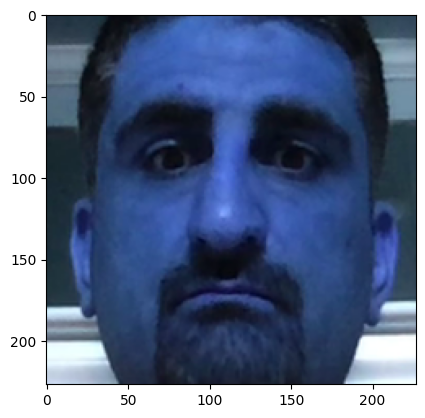

In [9]:
img = cv2.imread("/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0005.png")
img.shape
plt.imshow(img)

In [10]:
# print(os.listdir(trainPath))

# Loading the Images

In [11]:
labelToIndex = {
    'Non Drowsy' : 0,
    'Drowsy' : 1
}

In [34]:
x = []
y = []
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [38]:
def extract_eyes_to_array(image, label):
    if image is None:
        print(f"Error: Unable to parse image")
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     print("Gray Image Done")
    del image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
#     print("Face Detection Done")
    if faces is None:
        return None
    for (fx, fy, fw, fh) in faces:
        roi_gray = gray_image[fy:fy+fh, fx:fx+fw]
        eyes = eye_cascade.detectMultiScale(roi_gray)
#         print("Eyes detected")
        if eyes is None:
            return None
        for (ex, ey, ew, eh) in eyes:
            eye_img = roi_gray[ey:ey+eh, ex:ex+ew]
            resized_eye_img = cv2.resize(eye_img, (80, 80))
            sharpened_image = enhance_image_quality(resized_eye_img)
#             del resized_eye_img
            sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2BGR)
            sharpened_image = sharpened_image / 255.0
#             plt.imshow(sharpened_image)
#             return sharpened_image
            x.append(sharpened_image)
            del sharpened_image
            y.append(label)

In [39]:
def enhance_image_quality(image):
    if image is None:
        print(f"Error: Unable to parse image")
        return None
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 75   # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(adjusted, -1, kernel)
    return sharpened

[[[0.50980392 0.5254902  0.62352941]
  [0.6        0.72156863 0.97254902]
  [0.68627451 0.78823529 0.94117647]
  ...
  [0.69411765 0.9372549  1.        ]
  [0.75294118 0.96078431 1.        ]
  [0.69411765 0.90196078 1.        ]]

 [[0.49411765 0.58039216 0.59215686]
  [0.49803922 0.65882353 0.92941176]
  [0.64705882 0.8        0.94509804]
  ...
  [0.68627451 0.9372549  1.        ]
  [0.74117647 0.95294118 1.        ]
  [0.69019608 0.90196078 1.        ]]

 [[0.51764706 0.58823529 0.60392157]
  [0.4745098  0.67843137 0.96078431]
  [0.69803922 0.82352941 1.        ]
  ...
  [0.74117647 1.         1.        ]
  [0.76078431 0.95686275 1.        ]
  [0.69411765 0.88627451 1.        ]]

 ...

 [[0.52156863 0.70588235 1.        ]
  [0.54509804 0.74509804 1.        ]
  [0.63137255 0.78431373 1.        ]
  ...
  [0.81176471 0.99607843 1.        ]
  [0.77647059 0.94117647 1.        ]
  [0.69803922 0.87058824 1.        ]]

 [[0.5372549  0.6745098  1.        ]
  [0.58823529 0.81568627 1.        ]


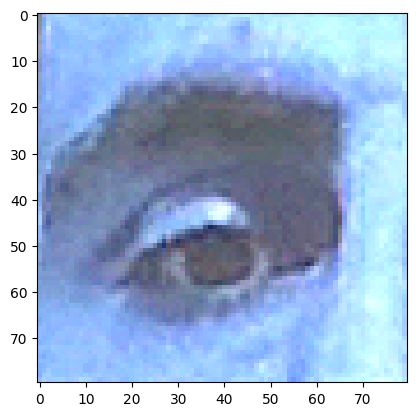

In [40]:
# image = cv2.imread("/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0010.png")
# image = extract_eyes_to_array(image, 0)
# print(image)
# plt.imshow(image)

In [13]:
def loadImages(path):
    for label in os.listdir(trainPath):
        path = os.path.join(trainPath, label)
        for img in tqdm(os.listdir(path)):
            image = cv2.imread(os.path.join(path, img))
            extract_eyes_to_array(image, labelToIndex[label])
            image = cv2.resize(image, (80, 80))
#             image = enhance_image_quality(image)
            image = image / 255.0
            x.append(image)
            y.append(labelToIndex[label])
            del image

In [14]:
# loadImages(trainPath)

In [15]:
# x = np.array(x, dtype = np.float16)
# y = np.array(y, dtype = np.float16)

# Preparing the images for model training

In [16]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
# del x
# del y
# x_train = np.array(x_train, dtype = np.float16).reshape(-1, 80, 80, 3)
# x_test = np.array(x_test, dtype = np.float16).reshape(-1, 80, 80, 3)
# y_train = np.array(y_train, dtype = np.float16)
# y_test = np.array(y_test, dtype = np.float16)

In [17]:
x_train = pickle.load(open("/kaggle/input/driversafety/x_train.pkl", "rb"))
x_test = pickle.load(open("/kaggle/input/driversafety/x_test.pkl", "rb"))
y_train = pickle.load(open("/kaggle/input/driversafety/y_train.pkl", "rb"))
y_test = pickle.load(open("/kaggle/input/driversafety/y_test.pkl", "rb"))

In [18]:
print(np.array(x_train).shape)
print(np.array(y_train).shape)

(65090, 80, 80, 3)
(65090,)


# Models

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

### 1. Custom CNN Model

In [20]:
model1 = Sequential()

## CNN 1
model1.add(Conv2D(32,(3,3),activation='relu',input_shape=(80, 80, 3)))
model1.add(BatchNormalization())
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.3))

## CNN 2
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.3))

## CNN 3
model1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.5))

## Output
model1.add(Flatten())
model1.add(Dense(512,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(1,activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# model1.summary()

In [22]:
model1.compile(loss = BinaryCrossentropy(), metrics = ['accuracy'], optimizer = Adam(0.0003))

In [23]:
model1.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/10
   5/2035 ━━━━━━━━━━━━━━━━━━━━ 1:05 32ms/step - accuracy: 0.5401 - loss: 0.9102  

I0000 00:00:1720772821.017029     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720772821.043923     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2035/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8037 - loss: 0.4355

W0000 00:00:1720772872.809818     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720772880.218145     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.09846, saving model to best_model.keras


W0000 00:00:1720772886.810453     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2035/2035 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - accuracy: 0.8037 - loss: 0.4355 - val_accuracy: 0.9666 - val_loss: 0.0985
Epoch 2/10
2032/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9504 - loss: 0.1343
Epoch 2: val_loss did not improve from 0.09846
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.9504 - loss: 0.1343 - val_accuracy: 0.7982 - val_loss: 0.9388
Epoch 3/10
2032/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9536 - loss: 0.1289
Epoch 3: val_loss improved from 0.09846 to 0.04758, saving model to best_model.keras
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9537 - loss: 0.1289 - val_accuracy: 0.9821 - val_loss: 0.0476
Epoch 4/10
2032/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9706 - loss: 0.0817
Epoch 4: val_loss did not improve from 0.04758
2035/2035 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.9706 - loss: 0.0817 - val_accuracy: 0.9729 - val_loss: 0.0745
Epoch 5/10
2034/2035 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9

### 2. ResNet50

In [40]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(80, 80, 3)))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
# model2.summary()

In [42]:
model2.compile(optimizer=Adam(0.0003), loss=BinaryCrossentropy(), metrics=['accuracy'])
history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
 5/88 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7741 - loss: 0.5662

W0000 00:00:1720723579.007424     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9007 - loss: 0.2536

W0000 00:00:1720723587.638169     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720723591.919201     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss did not improve from 0.05220
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.9011 - loss: 0.2525 - val_accuracy: 0.9167 - val_loss: 0.2966
Epoch 2/10
 3/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9826 - loss: 0.0596

W0000 00:00:1720723594.806112     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9797 - loss: 0.0768
Epoch 2: val_loss did not improve from 0.05220
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9797 - loss: 0.0767 - val_accuracy: 0.9542 - val_loss: 0.2276
Epoch 3/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9817 - loss: 0.0619
Epoch 3: val_loss did not improve from 0.05220
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9817 - loss: 0.0619 - val_accuracy: 0.9900 - val_loss: 0.0792
Epoch 3: early stopping


### 3. VGG16

In [43]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(80, 80, 3)))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [44]:
# model3.summary()

In [45]:
model3.compile(optimizer=Adam(0.0003), loss=BinaryCrossentropy(), metrics=['accuracy'])
history3 = model3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)k

Epoch 1/10
 7/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6782 - loss: 0.6038

W0000 00:00:1720723611.522243     151 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8974 - loss: 0.2362

W0000 00:00:1720723618.960829     152 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720723620.123845     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss did not improve from 0.05220
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.8980 - loss: 0.2350 - val_accuracy: 0.8850 - val_loss: 0.3022
Epoch 2/10
 7/88 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9850 - loss: 0.0690

W0000 00:00:1720723621.480148     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9822 - loss: 0.0707
Epoch 2: val_loss did not improve from 0.05220
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9822 - loss: 0.0706 - val_accuracy: 0.9692 - val_loss: 0.1684
Epoch 3/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9816 - loss: 0.0535
Epoch 3: val_loss improved from 0.05220 to 0.04883, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9818 - loss: 0.0534 - val_accuracy: 0.9883 - val_loss: 0.0488
Epoch 4/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9851 - loss: 0.0481
Epoch 4: val_loss improved from 0.04883 to 0.03170, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9852 - loss: 0.0479 - val_accuracy: 0.9933 - val_loss: 0.0317
Epoch 5/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9923 - loss: 0.0333
Epoch 5: val_loss improved from 0.03170 to 0.02389, saving model to best_model.keras
88/88 ━━━━━━━━━━━━━━━

In [46]:
res1 = model1.evaluate(x_test, y_test) # Custom CNN -> 99.43%
res2 = model2.evaluate(x_test, y_test) # ResNet50 -> 
res3 = model3.evaluate(x_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.0515
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9925 - loss: 0.0705
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9974 - loss: 0.0123


In [47]:
print(res1)
print(res2)
print(res3)

[0.06936764717102051, 0.9800000190734863]
[0.07919685542583466, 0.9900000095367432]
[0.019101852551102638, 0.9950000047683716]


In [48]:
model1.save("CustomCNNDrowsiness.keras")
model2.save("ResNet50Drowsiness.keras")
model3.save("VGG16Drowsiness.keras")

# import pickle
# pickle.dump(model1, open("CustomCNNDrowsiness.pkl", "wb"))
# pickle.dump(model2, open("ResNet50Drowsiness.pkl", "wb"))
# pickle.dump(model3, open("VGG16Drowsiness.pkl", "wb"))

In [ ]:
# Driver Drowsiness - Face (Validation Accuracy, Validation Loss)
# 1. Custom CNN -> 99.95%, 0.0011
# 2. ResNet50 -> 99.98%, 0.0004
# 3. VGG16 -> 99.97%, 0.0013

In [ ]:
# Driver Drowsiness - Eyes (Validation Accuracy, Validation Loss)
# 1. Custom CNN -> 98.64%, 0.0343
# 2. ResNet50 -> 98.61%, 0.0471
# 3. VGG16 -> 99.06%, 0.0293

In [ ]:
y_pred = model1.predict(x_test)
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)

axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                   cbar=True, cmap=plt.cm.BrBG)

class_labels = ["Non Drowsy", "Non Drowsy"]

axes.set_xlabel('Actual Values')
axes.set_ylabel('Predicted Values')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
